# Three-Controller Comparison

Simulate and compare three controllers on the same arrival sequence: the offline optimal baseline, a constant-gain linear controller, and the EGPC algorithm.


In [1]:
from pathlib import Path
import sys

PROJECT_ROOT = Path.cwd()
# Locate repo root so imports from src work even if notebook moves
while PROJECT_ROOT != PROJECT_ROOT.parent and not (PROJECT_ROOT / 'src').exists():
    PROJECT_ROOT = PROJECT_ROOT.parent

if not (PROJECT_ROOT / 'src').exists():
    raise RuntimeError("Could not locate 'src' directory relative to this notebook")

if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))


In [2]:
import numpy as np

from src.offline_opt import solve_optimal_w
from src.simulate_storage_dynamics import simulate_storage_dynamics
from src.egpc import run_egpc
from src.plots import compare_controllers


In [3]:
# Simulation configuration
T = 1000            # horizon length
H = 100             # feature dimension for w* and EGPC
kappa = 0.01         # decay parameter for feature construction
K_linear = 0.53     # constant feedback gain for the linear controller (0 <= K <= 1)
a_mode = 'arrivals_sinusoidal_rand'   # arrivals key from ARRIVAL_FUNCTIONS
cost_key = 'sin_randomized'  # cost key from COST_FUNCTIONS

L_u = 2.6           # Lipschitz surrogate constant for u
L_b = 5.0           # Lipschitz surrogate constant for b
b0 = 0.0           # initial backlog for manual simulations


#L = L_u + L_b / kappa
L = L_u + L_b 
eta = np.sqrt(np.log(H) / (T * (0.5 + 1.0 / kappa))) / L * 5000
eta = np.sqrt(np.log(H)/T) / L
print(f'Configured EGPC step size eta={eta:.4f}')


Configured EGPC step size eta=0.0089


In [4]:
def simulate_constant_gain(K, arrivals, cost_fn, *, b0=0.0, cost_kwargs=None):
    '''Simulate u_t = K * b_t with backlog recursion b_{t+1} = b_t - u_t + a_t.'''
    K_clipped = float(np.clip(K, 0.0, 1.0))
    T = len(arrivals)
    cost_kwargs = {} if cost_kwargs is None else dict(cost_kwargs)
    b_levels = np.empty(T)
    u_actions = np.empty(T)
    costs = np.empty(T)
    b_t = float(b0)
    for t in range(T):
        b_levels[t] = b_t
        u_t = K_clipped * b_t
        u_actions[t] = u_t
        costs[t] = cost_fn(b_t, u_t, t + 1, **cost_kwargs)
        b_t = b_t - u_t + arrivals[t]
    return {'b': b_levels, 'u': u_actions, 'c': costs}


In [5]:
# Offline optimal controller w*
opt_result = solve_optimal_w(
    a_mode=a_mode,
    cost_key=cost_key,
    T=T,
    H=H,
    kappa=kappa,
    verbose=False,
)

a = opt_result['a']
cost_fn = opt_result['cost_fn']
cost_kwargs = opt_result.get('cost_kwargs', {})
Phi = opt_result['Phi']
Psi = opt_result['Psi']
w_star = opt_result['w_star']

opt_sim = simulate_storage_dynamics(
    Phi,
    Psi,
    a,
    w_star,
    cost_fn=cost_fn,
    cost_kwargs=cost_kwargs,
)
print(f"Offline optimal total cost: {opt_sim['total_cost']:.4f}")



──────────────────────────────
Optimal weight vector found for 'arrivals_sinusoidal_rand' | cost='sin_randomized'
Objective value: 646.0939
w* (rounded): [0.9091 0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.0979 0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.    ]
Sum(w*): 1.0071
──────────────────────────────
Offline optimal total cost: 646.0939


/home/kamiar/PHD/Adversarial-Online-Control-for-Finite-Capacity-Storage/.venv/lib/python3.12/site-packages/cvxpy/problems/problem.py:1539: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


In [6]:
# Constant-gain linear controller
linear_sim = simulate_constant_gain(
    K_linear,
    a,
    cost_fn,
    b0=b0,
    cost_kwargs=cost_kwargs,
)
print(f"Linear controller total cost: {float(np.sum(linear_sim['c'])):.4f}")


Linear controller total cost: 984.5877


In [7]:
# EGPC controller on the same arrivals
def replay_arrivals(T_requested, amplitude=1.0, **kwargs):
    if T_requested != len(a):
        raise ValueError(f'Expected horizon {len(a)}, received {T_requested}.')
    return a.copy()


egpc_result = run_egpc(
    a_fn=replay_arrivals,
    cost_fn=cost_fn,
    cost_kwargs=cost_kwargs,
    eta=eta,
    H=H,
    T=T,
    kappa=kappa,
)
print(f"EGPC total cost: {egpc_result['total_cost']:.4f}")


EGPC total cost: 904.6158


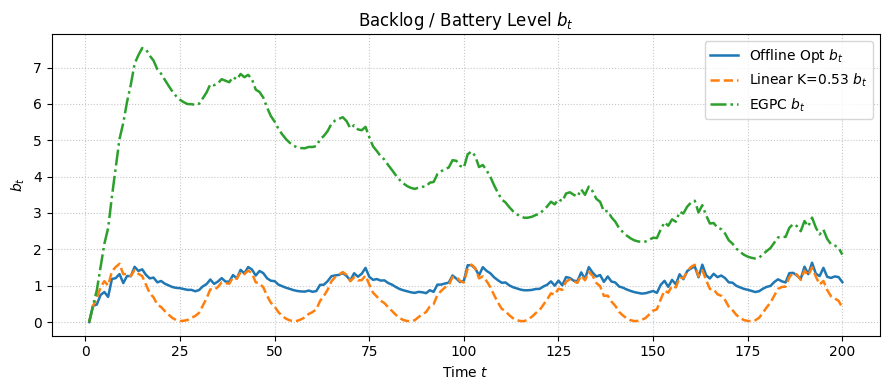

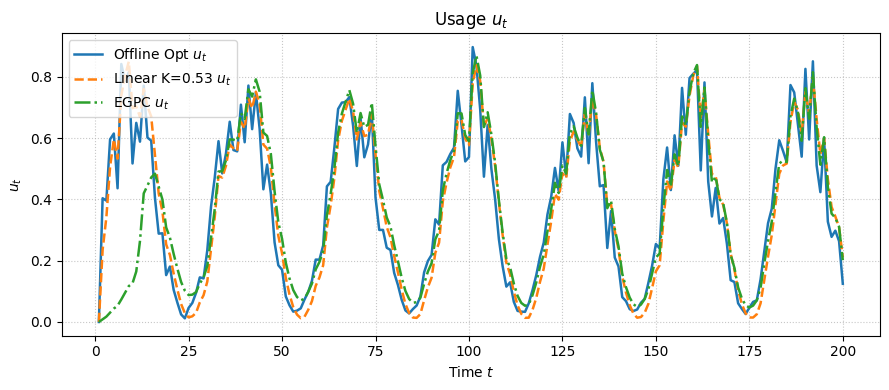

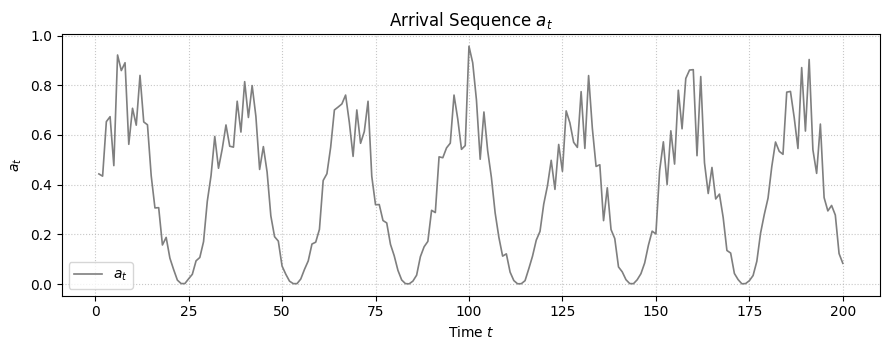

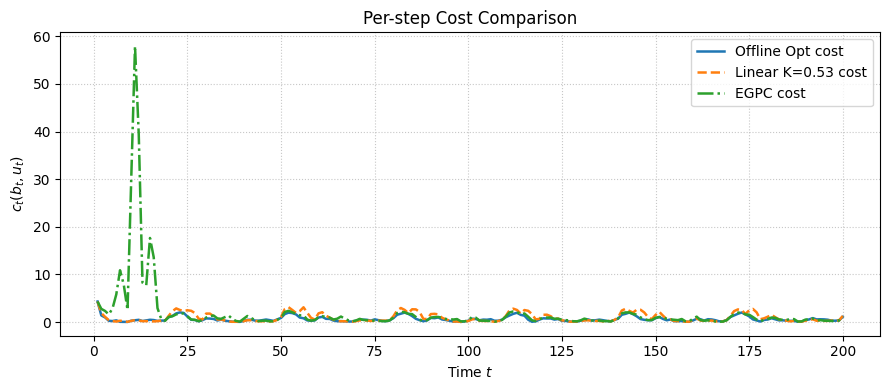


──────────────────────────────
Offline Opt     Total cost: 646.0939
Linear K=0.53   Total cost: 984.5877
EGPC            Total cost: 904.6158
──────────────────────────────


{'total_costs': {'Offline Opt': 646.0938947524811,
  'Linear K=0.53': 984.5877272531968,
  'EGPC': 904.6158051802255},
 'pairwise_abs_diff': {'Offline Opt vs Linear K=0.53': {'b_diff': 0.40265316769764176,
   'u_diff': 0.06526175156388268,
   'cost_diff': 0.4034924179445746},
  'Offline Opt vs EGPC': {'b_diff': 2.9064966795850484,
   'u_diff': 0.0858689897975157,
   'cost_diff': 1.2298633821026348},
  'Linear K=0.53 vs EGPC': {'b_diff': 3.2848457241194318,
   'u_diff': 0.060759809367919713,
   'cost_diff': 1.3921614903012023}},
 'total_cost_1': 646.0938947524811,
 'total_cost_2': 984.5877272531968,
 'b_diff': 0.40265316769764176,
 'u_diff': 0.06526175156388268,
 'cost_diff': 0.4034924179445746,
 'plot_window': {'start': 0, 'end': 200}}

In [8]:
plot_horizon = 200  # number of steps to display in plots
plot_start = 0  # starting index for plots

# Visual comparison of all three controllers
comparison_metrics = compare_controllers(
    opt_sim, 'Offline Opt',
    linear_sim, f'Linear K={K_linear:.2f}',
    egpc_result, 'EGPC',
    a=a,
    plot_arrival_separately=True,
    plot_start=plot_start,
    plot_end=plot_start + plot_horizon,
)
comparison_metrics


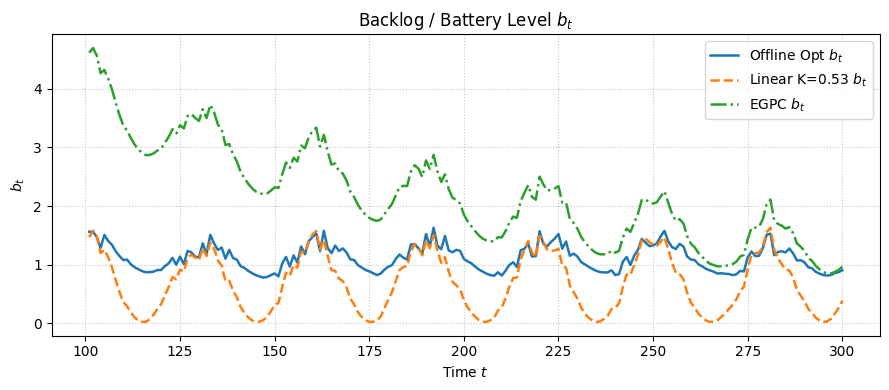

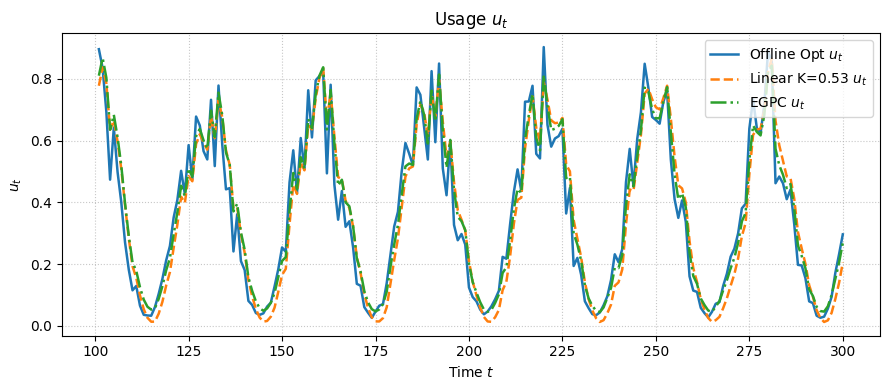

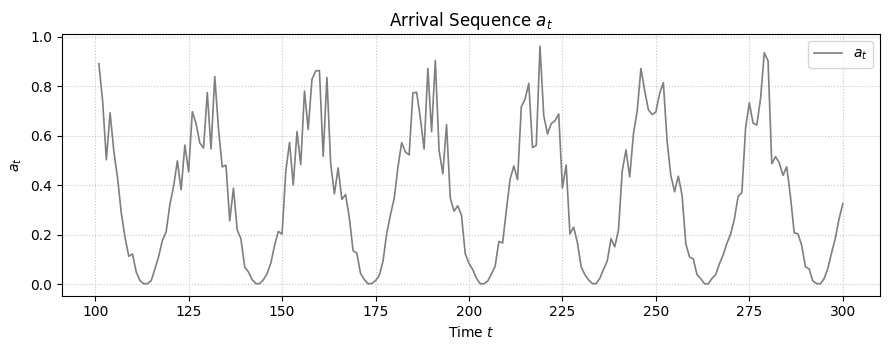

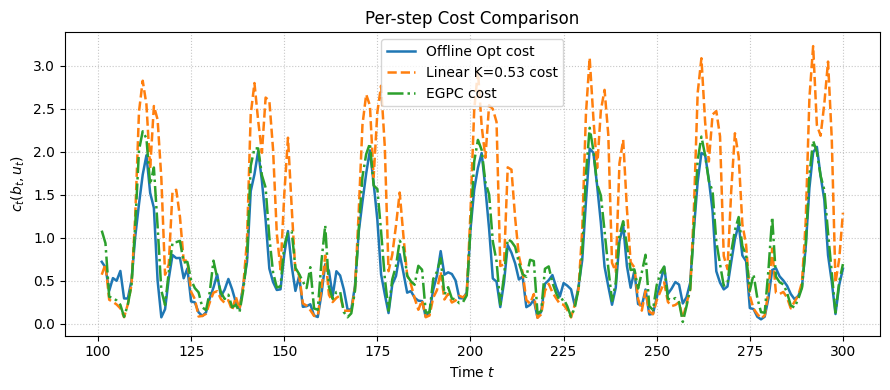


──────────────────────────────
Offline Opt     Total cost: 646.0939
Linear K=0.53   Total cost: 984.5877
EGPC            Total cost: 904.6158
──────────────────────────────


{'total_costs': {'Offline Opt': 646.0938947524811,
  'Linear K=0.53': 984.5877272531968,
  'EGPC': 904.6158051802255},
 'pairwise_abs_diff': {'Offline Opt vs Linear K=0.53': {'b_diff': 0.43644220011373536,
   'u_diff': 0.06529598177685493,
   'cost_diff': 0.44254223037004764},
  'Offline Opt vs EGPC': {'b_diff': 1.0818924255137283,
   'u_diff': 0.04536784820030137,
   'cost_diff': 0.1665251205889177},
  'Linear K=0.53 vs EGPC': {'b_diff': 1.5097923981422623,
   'u_diff': 0.027043583610767846,
   'cost_diff': 0.3711168215007596}},
 'total_cost_1': 646.0938947524811,
 'total_cost_2': 984.5877272531968,
 'b_diff': 0.43644220011373536,
 'u_diff': 0.06529598177685493,
 'cost_diff': 0.44254223037004764,
 'plot_window': {'start': 100, 'end': 300}}

In [9]:
plot_horizon = 200  # number of steps to display in plots
plot_start = 100  # starting index for plots

# Visual comparison of all three controllers
comparison_metrics = compare_controllers(
    opt_sim, 'Offline Opt',
    linear_sim, f'Linear K={K_linear:.2f}',
    egpc_result, 'EGPC',
    a=a,
    plot_arrival_separately=True,
    plot_start=plot_start,
    plot_end=plot_start + plot_horizon,
)
comparison_metrics


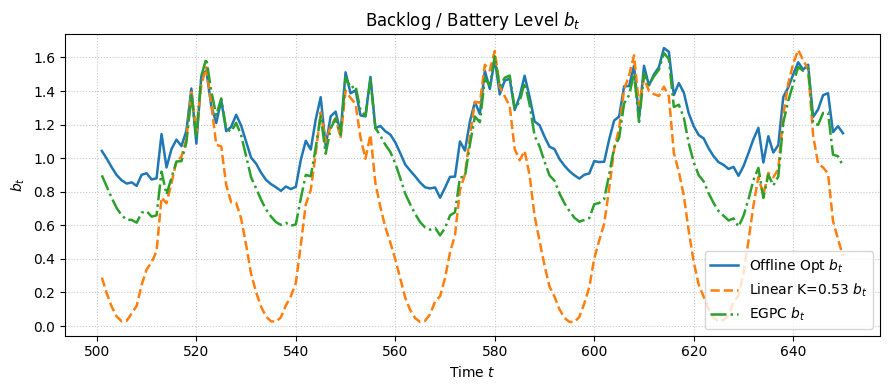

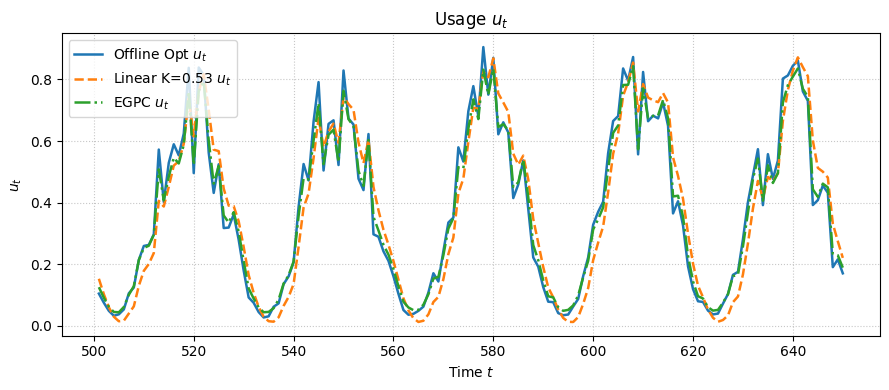

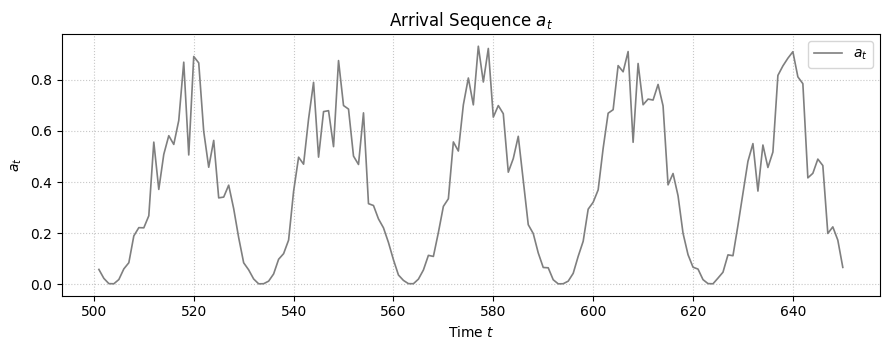

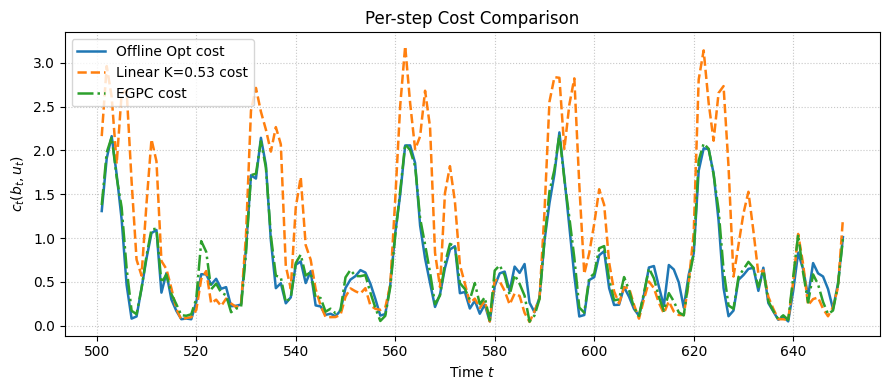


──────────────────────────────
Offline Opt     Total cost: 646.0939
Linear K=0.53   Total cost: 984.5877
EGPC            Total cost: 904.6158
──────────────────────────────


{'total_costs': {'Offline Opt': 646.0938947524811,
  'Linear K=0.53': 984.5877272531968,
  'EGPC': 904.6158051802255},
 'pairwise_abs_diff': {'Offline Opt vs Linear K=0.53': {'b_diff': 0.43892927103143753,
   'u_diff': 0.06736081330392642,
   'cost_diff': 0.4372933117887901},
  'Offline Opt vs EGPC': {'b_diff': 0.14114716330322338,
   'u_diff': 0.02259704952444104,
   'cost_diff': 0.07650216903257609},
  'Linear K=0.53 vs EGPC': {'b_diff': 0.3155282163590819,
   'u_diff': 0.050564554132940386,
   'cost_diff': 0.39730498116913426}},
 'total_cost_1': 646.0938947524811,
 'total_cost_2': 984.5877272531968,
 'b_diff': 0.43892927103143753,
 'u_diff': 0.06736081330392642,
 'cost_diff': 0.4372933117887901,
 'plot_window': {'start': 500, 'end': 650}}

In [10]:
plot_horizon = 150  # number of steps to display in plots
plot_start = 500  # starting index for plots

# Visual comparison of all three controllers
comparison_metrics = compare_controllers(
    opt_sim, 'Offline Opt',
    linear_sim, f'Linear K={K_linear:.2f}',
    egpc_result, 'EGPC',
    a=a,
    plot_arrival_separately=True,
    plot_start=plot_start,
    plot_end=plot_start + plot_horizon,
)
comparison_metrics
